### Class Activation Maps (CAMs) for for classifying the COVID and Normal CXR

This notebook demonstrates the following three major concepts:
1. Data preparation
2. Building model using transfer larning
3. Generating class activation maps

#### Import all necessary libraries

In [4]:
import cv2
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
from glob import glob

from keras.layers import Conv2D, MaxPool2D, Dropout, Activation, Dense, Flatten
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import load_img, ImageDataGenerator
import keras

### 1. Dataset Preparation

In [5]:
train_dir = "covid_vs_nor/train"
val_dir = "covid_vs_nor/val"
test_dir = "covid_vs_nor/test"
class_names=os.listdir(train_dir)
print(class_names)

['covid', 'normal']


In [6]:
train_datagen = ImageDataGenerator(zoom_range=0.15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15)
test_datagen = ImageDataGenerator()

In [7]:
bs = 16
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224,224),
                                                    batch_size=bs,
                                                    shuffle=True,
                                                    class_mode='categorical')

val_data = train_datagen.flow_from_directory(val_dir, target_size=(224,224),
                                                  batch_size=bs,
                                                  shuffle=True,
                                                  class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir, target_size=(224,224),
                                                  batch_size=bs,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 11044 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1382 images belonging to 2 classes.


### 2. Building model using transfer leanring
We already have a trained VGG16 model to classify the COVID and Normal CXRs. The model was saved in JSON format. In this section we will load that saved model (.json) with the saved weights (.h5) file. However, we need to fine tune the top dense layers to generate the CAMs. So, we will fine the loaded model and trian the network again!

#### Load the saved model (.json and .h5 file)

In [13]:
from keras.models import model_from_json
json_file = open("models/vgg16/vgg16_model.json", "r")
saved_json_model = json_file.read()
json_file.close()

saved_model = model_from_json(saved_json_model)
saved_model.load_weights("models/vgg16/best_model.h5")
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__________

#### Freeze the first 18 layers of the VGG16 model

In [17]:
for layer in saved_model.layers[:18]:
    layer.trainable = False

#### Remove the top dense layers and add new dense layers according to our purpose

In [22]:
X = saved_model.layers[-4].output
X = Dense(1024, activation='relu')(X)
X = Dense(512, activation='relu')(X)
output = Dense(2, activation='softmax')(X)
model = Model(inputs=saved_model.input, outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

#### Check the trainable and non-trainable layers
In this case, only the top dense layers are trainable, others are non-trainable

In [23]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001DC02B728D0> False
<keras.layers.convolutional.Conv2D object at 0x000001DC02B72898> False
<keras.layers.convolutional.Conv2D object at 0x000001DC02B72CF8> False
<keras.layers.pooling.MaxPooling2D object at 0x000001DC02B9DEB8> False
<keras.layers.convolutional.Conv2D object at 0x000001DC02B72B70> False
<keras.layers.convolutional.Conv2D object at 0x000001DC02BD49E8> False
<keras.layers.pooling.MaxPooling2D object at 0x000001DC02E26320> False
<keras.layers.convolutional.Conv2D object at 0x000001DC02B9DB00> False
<keras.layers.convolutional.Conv2D object at 0x000001DC02E264A8> False
<keras.layers.convolutional.Conv2D object at 0x000001DC03264EB8> False
<keras.layers.pooling.MaxPooling2D object at 0x000001DC032A1320> False
<keras.layers.convolutional.Conv2D object at 0x000001DC02E49908> False
<keras.layers.convolutional.Conv2D object at 0x000001DC032A14A8> False
<keras.layers.convolutional.Conv2D object at 0x000001DC032DEEB8> False
<ker

#### Compile the model and set modelcheckpoint

In [24]:
opt = Adam(1e-4)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [25]:
es = EarlyStopping(monitor='val_acc', verbose=1, mode='max', patience=20)
mc = ModelCheckpoint(filepath='models/vgg16/best_model_tl.h5',
                    monitor='val_acc',
                    mode='max',
                    save_best_only=True)

#### Train the model

In [26]:
trained_model = model.fit_generator(train_data,
                                    validation_data=val_data,
                                    epochs=50,
                                    steps_per_epoch=11044/bs,
                                    validation_steps=1380//bs,
                                    verbose=1,
                                    callbacks=[mc,es])

Epoch 1/50
691/690 [==============================] - 371s 536ms/step - loss: 0.0942 - acc: 0.9655 - val_loss: 0.1483 - val_acc: 0.9477
Epoch 2/50
691/690 [==============================] - 132s 190ms/step - loss: 0.0652 - acc: 0.9758 - val_loss: 0.1310 - val_acc: 0.9494
Epoch 3/50
691/690 [==============================] - 132s 191ms/step - loss: 0.0590 - acc: 0.9782 - val_loss: 0.1481 - val_acc: 0.9494
Epoch 4/50
691/690 [==============================] - 132s 191ms/step - loss: 0.0581 - acc: 0.9765 - val_loss: 0.1301 - val_acc: 0.9575
Epoch 5/50
691/690 [==============================] - 133s 193ms/step - loss: 0.0553 - acc: 0.9792 - val_loss: 0.1795 - val_acc: 0.9472
Epoch 6/50
691/690 [==============================] - 131s 189ms/step - loss: 0.0539 - acc: 0.9793 - val_loss: 0.1340 - val_acc: 0.9567
Epoch 7/50
691/690 [==============================] - 132s 191ms/step - loss: 0.0533 - acc: 0.9796 - val_loss: 0.1751 - val_acc: 0.9545
Epoch 8/50
691/690 [============================

#### Evaluate the trianed model with test data

In [27]:
model.evaluate_generator(test_data, 1382//16) 
# loss, accuracy
# model.metrics_names

[0.13815362666448278, 0.9622093023255814]

#### The training is done!! Now convert and save the model in JSON format so that we can directly use this model in future

In [28]:
model_json = model.to_json()
with open("models/vgg16/vgg16_model_tl.json", "w") as json_file:
    json_file.write(model_json)

### 3. Class Activation Maps

#### Import the necessary libraries if you work in a new notebook
As these libraries are already imported in this noteboo, so we are not importing here

In [33]:
# import cv2

# from keras.models import Model
# from keras.preprocessing import image
from keras.models import model_from_json
#from keras.optimizers import SGD, Adam

# import numpy as np
# import scipy as sp
# import matplotlib.pyplot as plt

# from glob import glob

#### Load the test images and display sample images

In [40]:
image_files_covid = glob("covid_vs_nor/test/covid/*.png")
image_files_normal = glob("covid_vs_nor/test/normal/*.png")

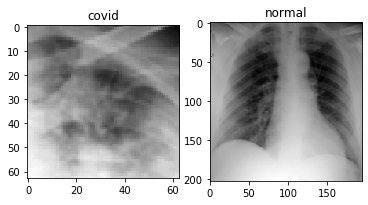

In [32]:
image_cov = cv2.imread(np.random.choice(image_files_covid), 0)
image_nor = cv2.imread(np.random.choice(image_files_normal), 0)

f, ax = plt.subplots(1, 2)
ax[0].imshow(image_cov, cmap='gray')
ax[0].set_title("covid")

ax[1].imshow(image_nor, cmap='gray')
ax[1].set_title("normal")

plt.show()


#### Load the newly trained JSON and .h5 which are saved before

In [151]:
json_file = open("models/vgg16/vgg16_model_tl.json", "r")
saved_json_model = json_file.read()
json_file.close()

saved_model = model_from_json(saved_json_model)
saved_model.load_weights("models/vgg16/best_model_tl.h5")
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

#### Get the feture prediction model and weights of the final dense layer

In [152]:
activation_layer = saved_model.get_layer('vgg16') # 'vgg16' is the last feature layers
fe_model = Model(inputs=saved_model.input, outputs=activation_layer.output)

In [153]:
final_dense = saved_model.get_layer('dense_6') #'dense_6' is the final dense layers
W = final_dense.get_weights()[0]
#len(W)

#### Get the features and weights for any specific image

In [154]:
path = image_files_covid
img = load_img(np.random.choice(path), target_size=(224, 224))
x = np.expand_dims(img, axis=0)

fmaps = fe_model.predict(x)[0] # 7 x 7 x 512

preds = saved_model.predict(x)[0] # prediction
pred = np.argmax(preds) # 0 for covid, 1 for normal
w = W[:, pred] # get the wiehgts (512) of the predicted level

#### Visualize features corrospondense to the top 9 weights

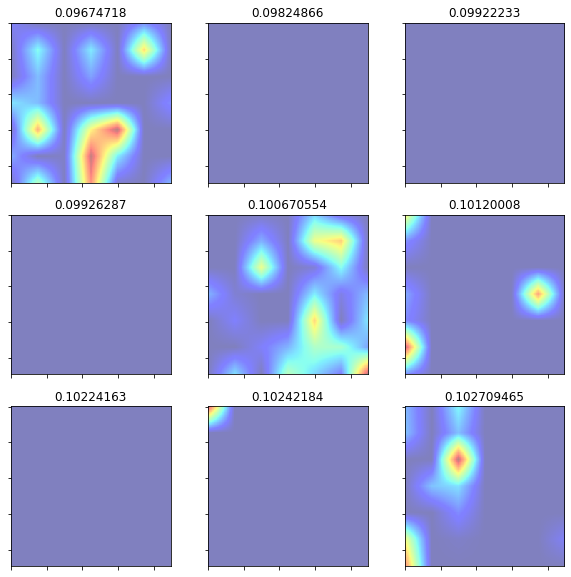

In [157]:
t9_idx = np.argsort(w)[-9:]
fe_with_t9_w = fmaps[:,:,t10_idx]

f,ax = plt.subplots(3,3, figsize=(10,10))
for i in range(9):
    fe = fe_with_t9_w[:,:,i]
    fe_zoomed = sp.ndimage.zoom(fe, (32, 32), order=1)
    ax[i//3][i%3].imshow(fe_zoomed, cmap='jet', alpha=0.5)
    ax[i//3][i%3].set_title(str(w[t9_idx[i]]))
    ax[i//3][i%3].set_xticklabels([])
    ax[i//3][i%3].set_yticklabels([])
plt.show()

#### Generate the CAMs and plot the images

P(covid) vs P(normal): 1.000 vs 0.000


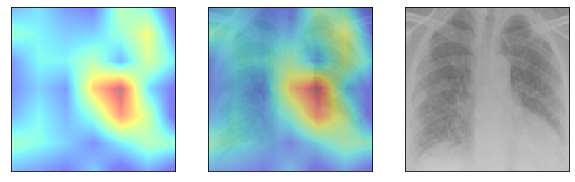

In [168]:
# "dot" w with fmaps
cam = fmaps.dot(w)

# upsample to 224 x 224
# 7 x 32 = 224
cam = sp.ndimage.zoom(cam, (32, 32), order=1)

# print the prediction result
print("P(covid) vs P(normal): {:.3f} vs {:.3f}".format(preds[0], preds[1]))

fig = plt.figure(figsize=(10,10))

plt.subplot(1,3,1) # only cam
plt.imshow(cam, cmap='jet', alpha=0.5) 
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2) # cam over cxr
plt.imshow(img, alpha=0.8)
plt.imshow(cam, cmap='jet', alpha=0.4)
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3) # original cxr
plt.imshow(img)
plt.xticks([]), plt.yticks([])
#plt.title(classname)
plt.show()

#### Create a function using the above three cells (Optional)

In [169]:
def cam_prediction(path):
    path = image_files_covid
    img = load_img(np.random.choice(path), target_size=(224, 224))
    x = np.expand_dims(img, axis=0)

    fmaps = fe_model.predict(x)[0] # 7 x 7 x 512

    preds = saved_model.predict(x)[0] # prediction
    pred = np.argmax(preds) # 0 for covid, 1 for normal
    w = W[:, pred] # get the wiehgts (512) of the predicted level
    
    # "dot" w with fmaps
    cam = fmaps.dot(w)

    # upsample to 224 x 224
    # 7 x 32 = 224
    cam = sp.ndimage.zoom(cam, (32, 32), order=1)

    # print the prediction result
    print("P(covid) vs P(normal): {:.3f} vs {:.3f}".format(preds[0], preds[1]))

    fig = plt.figure(figsize=(10,10))

    plt.subplot(1,3,1) # only cam
    plt.imshow(cam, cmap='jet', alpha=0.5) 
    plt.xticks([]), plt.yticks([])

    plt.subplot(1,3,2) # cam over cxr
    plt.imshow(img, alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.xticks([]), plt.yticks([])

    plt.subplot(1,3,3) # original cxr
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    #plt.title(classname)
    plt.show()

P(covid) vs P(normal): 1.000 vs 0.000


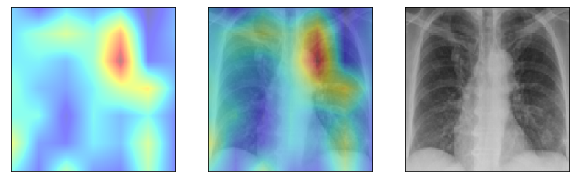

In [170]:
cam_prediction(image_files_covid)